<a href="https://colab.research.google.com/github/KevinMartinez1999/Machine_Learning/blob/develop/K_Means_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN_16QAM Modulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sofa import demapper_sym, BitErrorRate, SymbolErrorRate
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Generación y modulación

In [2]:
Ns = 10000
Mod = 16 #16QAM
Symbols_tx = np.random.randint(Mod, size = Ns)
df_sym_tx = pd.DataFrame(np.transpose(Symbols_tx), columns = ['data'])
df_sym_tx.head()

,data
0,14
1,5
2,4
3,14
4,14


In [3]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j,  #1000
            9:3+1j,  #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [4]:
#Modulación reemplazando símbolos por valores complejos (opción 1)
df_sym_mod = df_sym_tx.replace(mod_dict)
df_sym_mod.head(10)

,data
0,1.0-3.0j
1,-1.0+1.0j
2,-1.0+3.0j
3,1.0-3.0j
4,1.0-3.0j
5,3.0-3.0j
6,-1.0+1.0j
7,-1.0+1.0j
8,-3.0+1.0j
9,3.0+1.0j


In [5]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(10)

0    1.0-3.0j
1   -1.0+1.0j
2   -1.0+3.0j
3    1.0-3.0j
4    1.0-3.0j
5    3.0-3.0j
6   -1.0+1.0j
7   -1.0+1.0j
8   -3.0+1.0j
9    3.0+1.0j
Name: data, dtype: complex128

### Transmision canal AWGN

In [6]:
Xr = np.real(df_sym_mod['data'])
Xi = np.imag(df_sym_mod['data'])

In [7]:
# Adición de ruido blanco Gaussiano (AWGN)
# Se le adiciona diferentes cantidades de ruido para ver los efectos de 
# este en la demodulación.

target_snr_db = [i for i in np.arange(0, 21, 4)]
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)
#print(Xr_avg_db)
noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
#noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
noise_r= [np.random.normal(mean_noise, np.sqrt(i), len(Xr)) for i in noise_avg_p_r]
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
#noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
noise_i = [np.random.normal(mean_noise, np.sqrt(i), len(Xi)) for i in noise_avg_p_i]
Xi_ch = Xi + noise_i

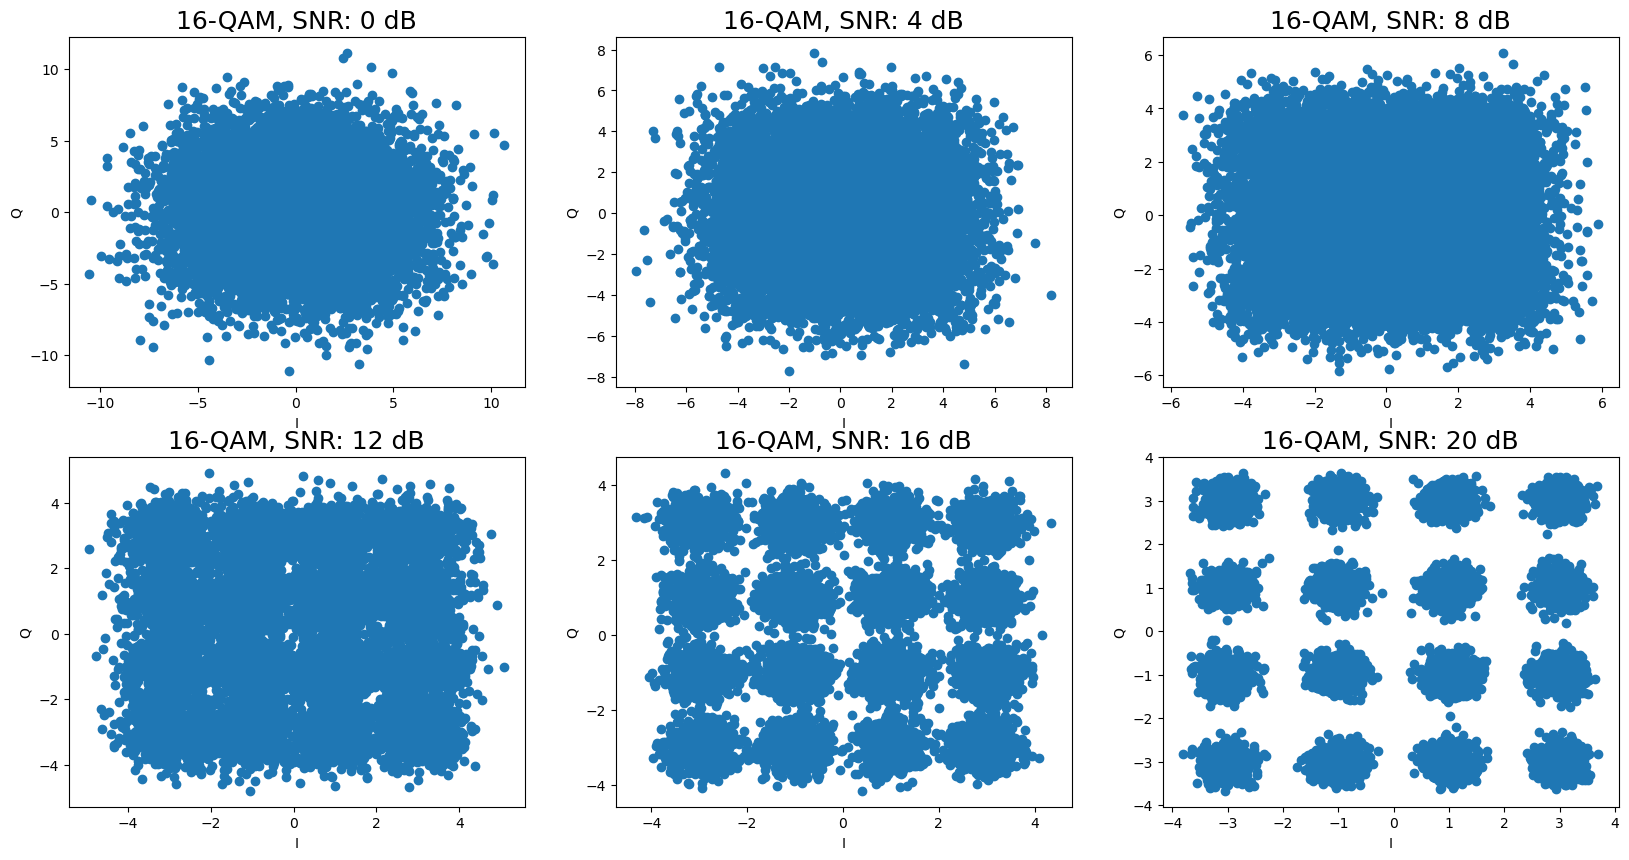

In [8]:
plt.figure(figsize=(20, 10))

for i in range(len(target_snr_db)):
  plt.subplot(2, 3, i+1)
  plt.title('16-QAM, SNR: '+str(target_snr_db[i])+' dB', fontsize = 18)
  plt.plot(Xi_ch[i], Xr_ch[i], 'o')
  plt.xlabel('I')
  plt.ylabel('Q')
plt.show()

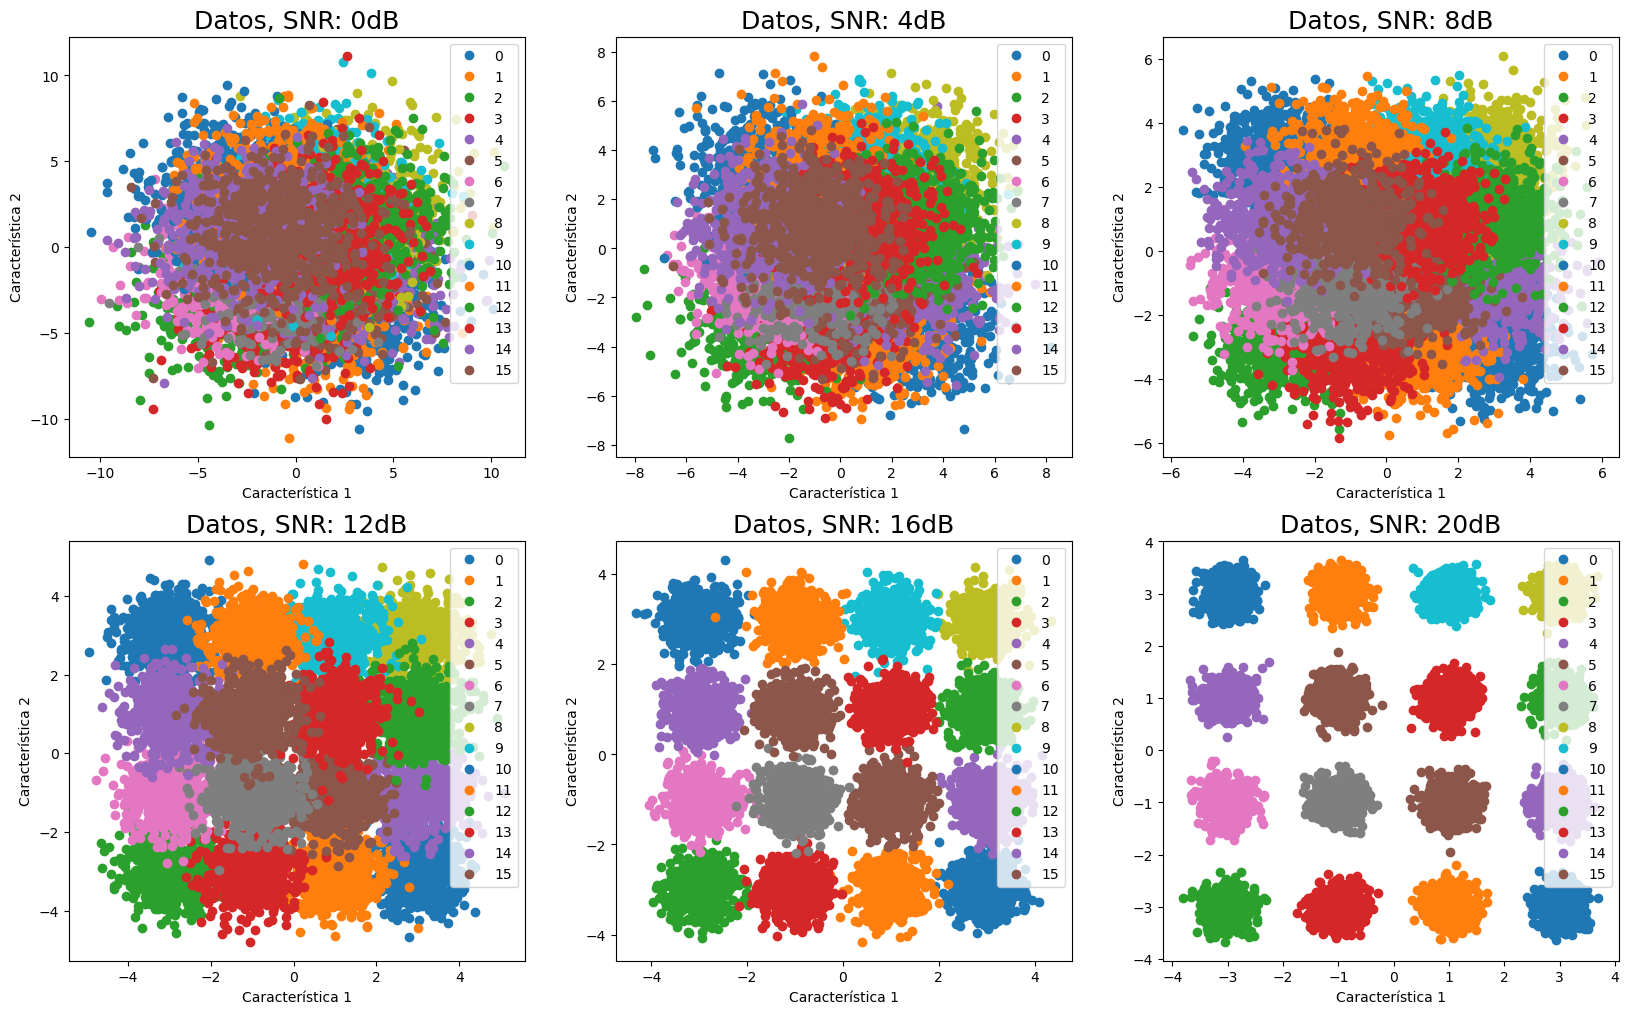

In [9]:
plt.figure(figsize=(20, 12))

for i in range(len(target_snr_db)):
  plt.subplot(2, 3, i+1)
  plt.title(f'Datos, SNR: {target_snr_db[i]}dB', fontsize = 18)
  for g in np.unique(Symbols_tx):
      ix = np.where(Symbols_tx == g)
      plt.plot(Xi_ch[i][ix], Xr_ch[i][ix], 'o', label = g)
  plt.legend(loc = 'upper right')
  plt.xlabel('Característica 1')
  plt.ylabel('Característica 2')

plt.show()

### Demodulación

In [10]:
sym_rx = [demapper_sym(Xr_ch[i], Xi_ch[i], len(Xr_ch[i]), threshold = 2.0) for i in range(len(target_snr_db))]
print(f'SNR {target_snr_db[0]}dB :', sym_rx[0][0:10])
print(f'SNR {target_snr_db[3]}dB:', sym_rx[3][0:10])
print('Original:', Symbols_tx[0:10])

SNR 0dB : [14, 2, 4, 14, 14, 9, 5, 13, 3, 8]
SNR 12dB: [14, 5, 4, 14, 14, 10, 5, 5, 1, 9]
Original: [14  5  4 14 14 10  5  5  1  9]


In [11]:
arr_SER = []
for i in range(len(target_snr_db)):
  SER, error = SymbolErrorRate(sym_rx[i], Symbols_tx)
  arr_SER.append(SER)
  print(f'SER {target_snr_db[i]}dB:', SER)
  print(f'Error {target_snr_db[i]}dB:', error, '\n')

SER 0dB: 0.7379
Error 0dB: 7379 

SER 4dB: 0.5872
Error 4dB: 5872 

SER 8dB: 0.3574
Error 8dB: 3574 

SER 12dB: 0.1101
Error 12dB: 1101 

SER 16dB: 0.0071
Error 16dB: 71 

SER 20dB: 0.0
Error 20dB: 0 



In [12]:
arr_BER = []
for i in range(len(target_snr_db)):
  BER, error = BitErrorRate(sym_rx[i], Symbols_tx)
  arr_BER.append(BER)
  print(f'SER {target_snr_db[i]}dB:', BER)
  print(f'Error {target_snr_db[i]}dB:', error, '\n')

SER 0dB: 0.286425
Error 0dB: 11457 

SER 4dB: 0.18685
Error 4dB: 7474 

SER 8dB: 0.098875
Error 8dB: 3955 

SER 12dB: 0.028325
Error 12dB: 1133 

SER 16dB: 0.001775
Error 16dB: 71 

SER 20dB: 0.0
Error 20dB: 0 



### Demodulación usando K Means

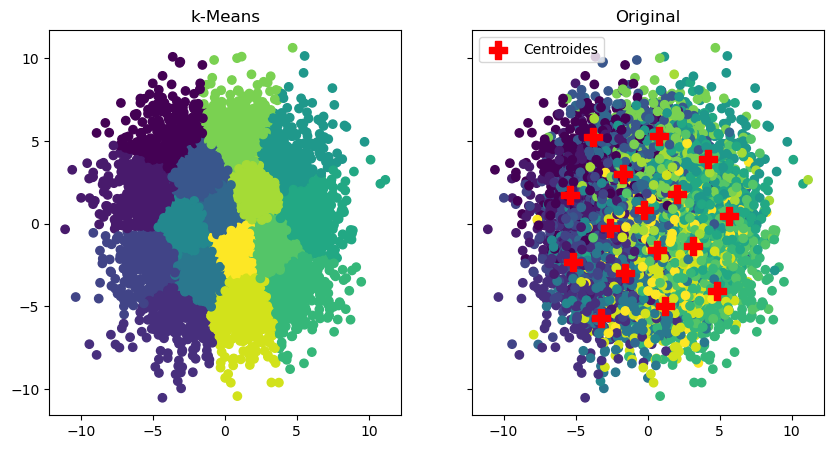

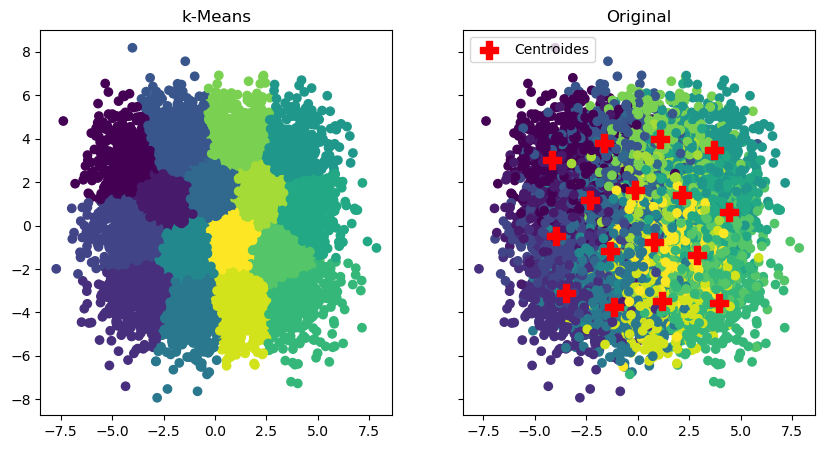

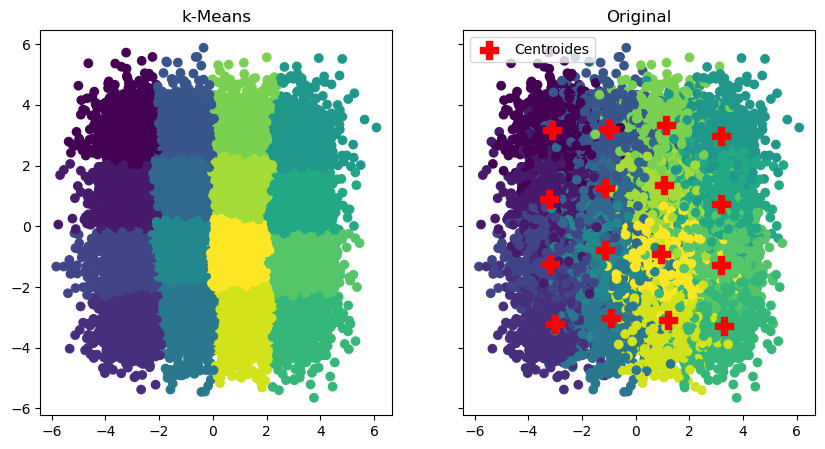

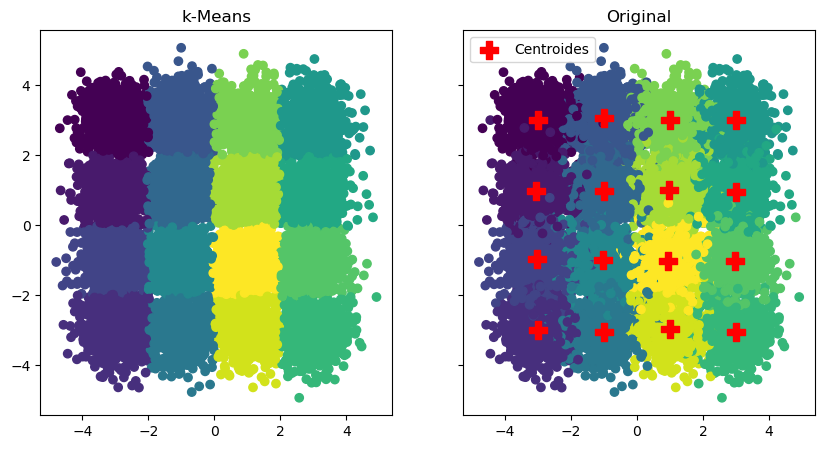

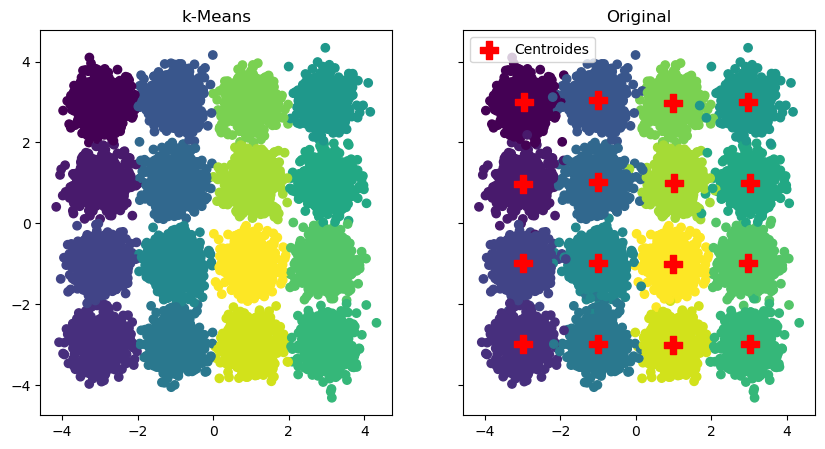

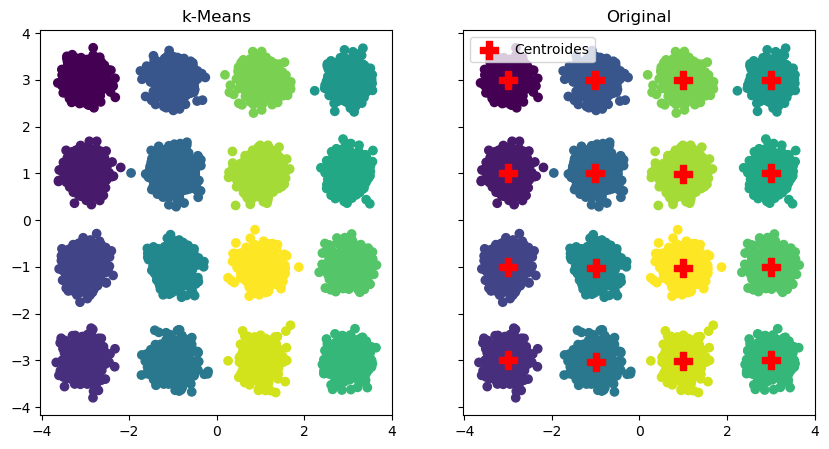

In [13]:
num_clusters = Mod
cent_init = np.array([[-3,3], [-3,1], [-3,-3],[-3,-1],
                      [-1,3],[-1,1],[-1,-3],[-1,-1],
                      [3,3],[3,1],[3,-3],[3,-1],[1,3],
                      [1,1],[1,-3],[1,-1]])
arr_BER_k_means = []
for i in range(len(target_snr_db)):
  X = np.transpose(np.array([Xr_ch[i], Xi_ch[i]]))
  y = Symbols_tx

  model = KMeans(n_clusters = num_clusters, init = cent_init, n_init = 1)
  model.fit(X)

  SER_test, error_SER = SymbolErrorRate(model.labels_, y)
  #print(f'SER: {SER_test}, Error sym: {error_SER}')

  BER_test, error_BER = BitErrorRate(model.labels_, y)
  #print(f'BER: {BER_test}, Error Bit: {error_BER}')

  arr_BER_k_means.append(BER_test)

  centers = model.cluster_centers_

  fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (10, 5))
  ax1.set_title('k-Means')
  ax1.scatter(X[:,0],X[:,1], c = model.labels_)
  ax2.set_title('Original')
  ax2.scatter(X[:,0],X[:,1], c = y)
  ax2.scatter(centers[:,0], centers[:,1], label = 'Centroides', s = 150, marker = 'P', color = 'red')
  ax2.legend(loc = 'upper left')

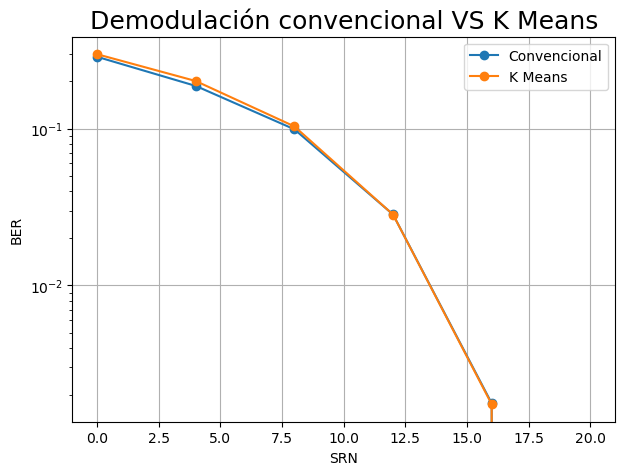

In [14]:
plt.figure(figsize=(7, 5))
plt.title('Demodulación convencional VS K Means', fontsize = 18)
plt.plot(target_snr_db, arr_BER[:], marker = 'o', label = 'Convencional')
plt.plot(target_snr_db, arr_BER_k_means, marker = 'o', label = 'K Means')
plt.xlabel('SRN')
plt.ylabel('BER')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()